In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
%matplotlib inline

In [2]:
import medpy # need to pip install itk as well
import medpy.io

In [3]:
p='/data/lisa/data/BRATS2013/Synthetic_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.865_N4ITK.mha'
image_data, image_header = medpy.io.load(p)

In [4]:
image_data = image_data.T

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

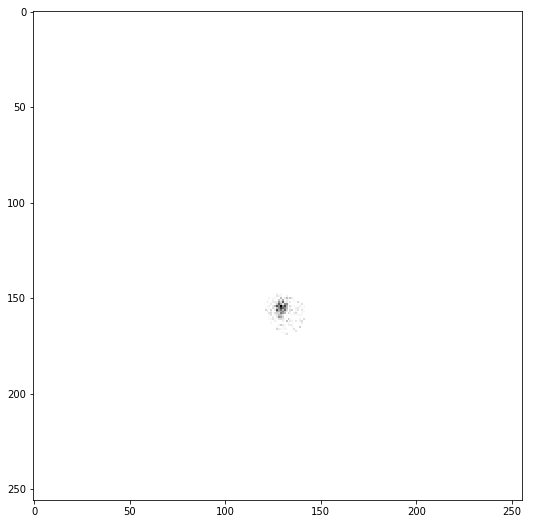

In [6]:
plt.rcParams['figure.figsize'] = (10, 9)
x_widget = ipywidgets.FloatSlider(min=0.0, max=image_data.shape[0], step=1);
interact(lambda(x): plt.imshow(image_data[int(x)], cmap='Greys'),x=x_widget);

In [7]:
basepath = "/data/lisa/data/BRATS2013"
import glob, os
import re

def get_data(glob_pattern):
    data = {}
    for filename in glob.iglob(glob_pattern):
        print ".",
        path = os.path.normpath(filename).split(os.sep)
        number = list(reversed(path))[2]
        level = list(reversed(path))[3]
        name = level+number
        #print name
        image_data, image_header = medpy.io.load(filename)
        image_data = image_data.T
        image_data = np.round(image_data) #maybe not the best?
        image_data = image_data.astype(np.uint32)
        data[name] = image_data
    return data


flair = get_data(basepath + "/Synthetic_Data/*/*/*/*Flair.*N4ITK.mha")
t1 = get_data(basepath + "/Synthetic_Data/*/*/*/*T1.*N4ITK.mha")
t1c = get_data(basepath + "/Synthetic_Data/*/*/*/*T1c.*N4ITK.mha")
t2 = get_data(basepath + "/Synthetic_Data/*/*/*/*T2.*N4ITK.mha")
labels = get_data(basepath + "/Synthetic_Data/*/*/*/*5more*N4ITK.mha")

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [17]:
labels['LG0001'].shape

(181, 256, 256)

In [8]:
def get_labels(rightside):
    met = {}
    met["brain"]    = (1.*(rightside!= 0).sum()/(rightside == 0).sum())
    met["tumor"]    = (1.*(rightside > 2).sum()/((rightside != 0).sum() + 1e-10))
    met["necrosis"] = (1.*(rightside > 3).sum()/((rightside != 0).sum() + 1e-10))
    
    met["has_enough_brain"] = met["brain"]     > 0.30
    met["has_tumor"]        = met["tumor"]     > 0.05
    met["has_necrosis"]     = met["necrosis"]  > 0.05
    return met
    
    

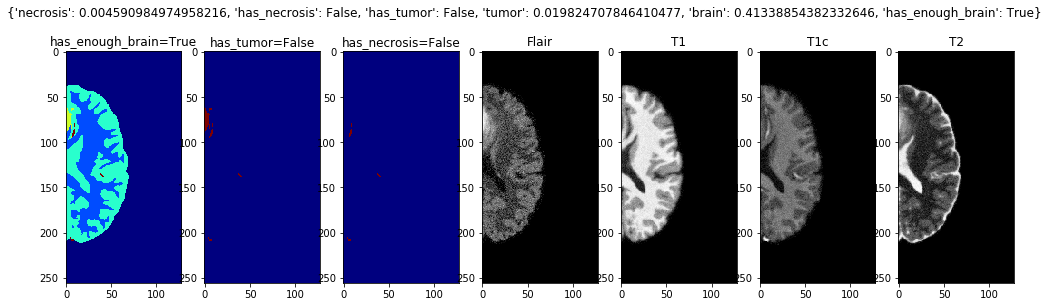

In [9]:
sample = 'HG0008'
slide = 90
label = labels[sample][slide][:,128:]
fla = flair[sample][slide][:,128:]
it1 = t1[sample][slide][:,128:]
it1c = t1c[sample][slide][:,128:]
it2 = t2[sample][slide][:,128:]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1,7);
axarr[0].imshow(label);
axarr[0].set_title("has_enough_brain="+ str(met["has_enough_brain"]))
axarr[1].imshow(label > 2);
axarr[1].set_title("has_tumor="+ str(met["has_tumor"]))
axarr[2].imshow(label > 3);
axarr[2].set_title("has_necrosis="+ str(met["has_necrosis"]))
axarr[3].imshow(1.0-fla, cmap='Greys');
axarr[3].set_title("Flair")
axarr[4].imshow(1.0-it1, cmap='Greys');
axarr[4].set_title("T1")
axarr[5].imshow(1.0-it1c, cmap='Greys');
axarr[5].set_title("T1c")
axarr[6].imshow(1.0-it2, cmap='Greys');
axarr[6].set_title("T2")

fig.suptitle(met, y=0.75);

In [10]:
# now create a dataframe and compute the label values

In [11]:
dataset = []
for sample in labels.keys():
    for slide in range(labels[sample].shape[0]):
        rightside = labels[sample][slide][:,128:]
        met = get_labels(rightside)
        met["sample"] = sample
        met["slide"] = slide
        dataset.append(met)
        #if met["has_enough_brain"]:
        met["flair"] = flair[sample][slide][:,128:]
        met["t1"] = t1[sample][slide][:,128:]

In [12]:
stats = pd.DataFrame(dataset)

In [13]:
stats[stats.has_enough_brain].head()

,brain,flair,has_enough_brain,has_necrosis,has_tumor,necrosis,sample,slide,t1,tumor
47,0.306904,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.021442,HG0018,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.269396
48,0.314611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019638,HG0018,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.253889
49,0.321503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018941,HG0018,49,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.246362
50,0.328630,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019741,HG0018,50,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.239605
51,0.338179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018476,HG0018,51,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.234513


In [14]:
tostudy = np.random.choice(stats["sample"].unique(), 20)

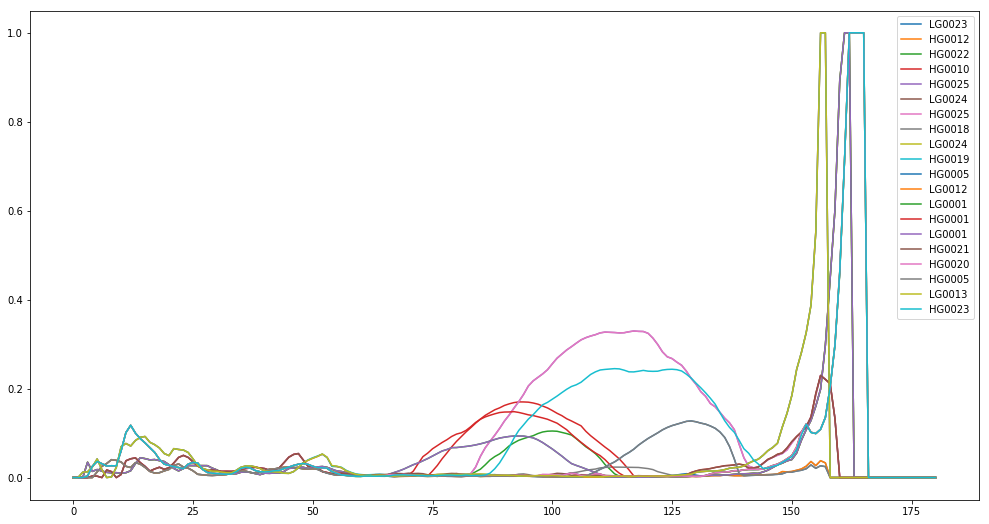

In [15]:
for sample in tostudy:
    plt.plot(stats[stats["sample"]==sample].slide, stats[stats["sample"]==sample].necrosis, label=sample);
plt.legend();

In [35]:
#build dataset
#stratify on two variables

In [16]:
#base = stats[stats.has_enough_brain][["sample", "slide", "has_tumor", "has_necrosis"]]
base = stats[stats.has_enough_brain]
base.shape

(3540, 10)

In [20]:
import collections
print "tumor", collections.Counter(base.has_tumor)
print "necrosis", collections.Counter(base.has_necrosis)

tumor Counter({True: 1990, False: 1550})
necrosis Counter({False: 2982, True: 558})


In [65]:
#np.savez(open("domaina.npz", "w"), np.asarray(list(domaina.flair.as_matrix())))

In [290]:
#np.savez(open("domainb.npz", "w"), np.asarray(list(domainb.t1.as_matrix())))

In [66]:
base.head()

,brain,flair,has_enough_brain,has_necrosis,has_tumor,necrosis,sample,slide,t1,tumor
47,0.306904,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.021442,HG0018,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.269396
48,0.314611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019638,HG0018,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.253889
49,0.321503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018941,HG0018,49,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.246362
50,0.328630,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019741,HG0018,50,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.239605
51,0.338179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018476,HG0018,51,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.234513


In [75]:
import sklearn, sklearn.model_selection
tosplit = (base.has_tumor+0 + base.has_necrosis+2)
train, holdout = sklearn.model_selection.train_test_split(base, stratify=tosplit, train_size=0.8)

In [76]:
print train.shape
print holdout.shape

(2832, 10)
(708, 10)


In [94]:
collections.Counter(train.has_tumor)

Counter({False: 1240, True: 1592})

In [92]:
def sample_ratio(samples, ratio_with_tumor, dataframe):
    num_withtumor = int(samples*ratio_with_tumor)
    num_notumor   = int(samples*(1.0-ratio_with_tumor))
    
    with_tumor    = np.random.choice(dataframe[dataframe.has_tumor == True].index, num_withtumor)
    without_tumor = np.random.choice(dataframe[dataframe.has_tumor == False].index, num_notumor)
    
    return dataframe.loc[np.concatenate([with_tumor, without_tumor],axis=0)]

In [116]:
domaina = sample_ratio(1000, 0.5, train)
domainb = sample_ratio(1000, 1.0, train)

In [103]:
collections.Counter(domainb.has_tumor)

Counter({True: 1000})

In [90]:
domainb.head()

,brain,flair,has_enough_brain,has_necrosis,has_tumor,necrosis,sample,slide,t1,tumor
4034,0.305758,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,True,0.053043,LG0009,52,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.053043
8435,0.342181,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,True,0.220493,LG0010,109,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.277831
2463,0.344990,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.007971,LG0005,110,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.240809
3366,0.352652,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.008779,LG0003,108,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.124429
5157,0.431230,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.004051,HG0002,89,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.133394


In [ ]:
path = "cyclegan/datasets/brats2013-var/"
for i in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print i
    domainb = sample_ratio(1000, i, train)
    print collections.Counter(domainb.has_tumor)
    thispath = path + "brats2013_" + str(i)
    if not os.path.exists(thispath):
        os.makedirs(thispath + "/trainA")
        os.makedirs(thispath + "/testA")
        os.makedirs(thispath + "/trainB")
        os.makedirs(thispath + "/testB")
    print thispath
        
    import skimage
    from skimage.io import imread, imsave

    for i, row in domaina.iterrows():
        img = row.flair
        imgg = 1.*img/img.max()
        name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
        imsave(thispath + "/trainA/" + name + ".png", imgg.astype(np.float32))
        imsave(thispath + "/testA/" + name + ".png", imgg.astype(np.float32))

    for i, row in domainb.iterrows():
        img = row.t1
        imgg = 1.*img/img.max()
        name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
        imsave(thispath + "/trainB/" + name + ".png", imgg.astype(np.float32))
        imsave(thispath + "/testB/" + name + ".png", imgg.astype(np.float32))
    

0.0
Counter({False: 1000})
cyclegan/datasets/brats2013-var/brats2013_0.0
0.1
Counter({False: 900, True: 100})
cyclegan/datasets/brats2013-var/brats2013_0.1
0.2
Counter({False: 800, True: 200})
cyclegan/datasets/brats2013-var/brats2013_0.2
0.3
Counter({False: 700, True: 300})
cyclegan/datasets/brats2013-var/brats2013_0.3
0.4
Counter({False: 600, True: 400})
cyclegan/datasets/brats2013-var/brats2013_0.4
0.5
Counter({False: 500, True: 500})
cyclegan/datasets/brats2013-var/brats2013_0.5
0.6
Counter({True: 600, False: 400})
cyclegan/datasets/brats2013-var/brats2013_0.6
0.7
Counter({True: 700, False: 300})
cyclegan/datasets/brats2013-var/brats2013_0.7
0.8
Counter({True: 800, False: 199})
cyclegan/datasets/brats2013-var/brats2013_0.8
0.9
Counter({True: 900, False: 99})
cyclegan/datasets/brats2013-var/brats2013_0.9
1.0
Counter({True: 1000})
cyclegan/datasets/brats2013-var/brats2013_1.0


In [114]:
A_img = imread("cyclegan/datasets/brats2013-var/brats2013_0.9/trainA/HG0003-114-True-True.png")

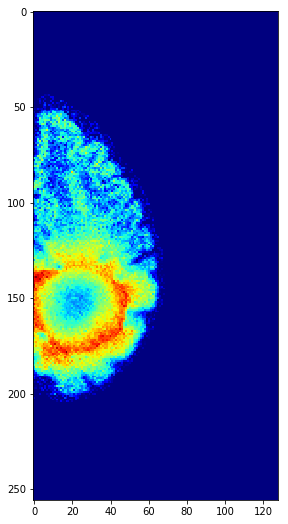

In [115]:
plt.imshow(A_img)